In [4]:
import os
import re
import matplotlib.pyplot as plt
import pandas as pd

# Accuracy Graphs

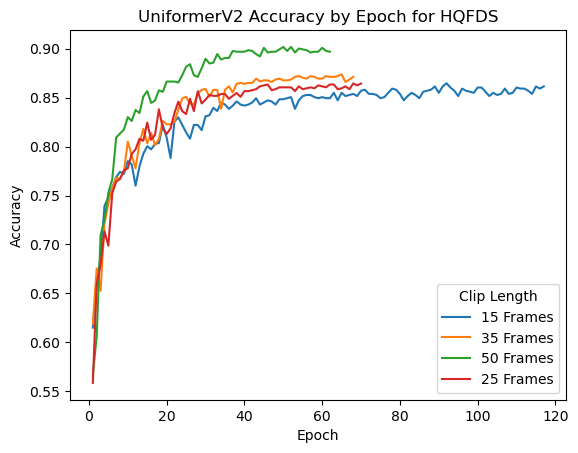

In [84]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

def parse_log_file(file_path):
    results = []
    
    with open(file_path, 'r') as f:
        content = f.read()
        
    # Find all validation results using regex
    val_pattern = r'Epoch\(val\)\s+\[(\d+)\].*?acc/top1:\s+([\d.]+).*?confusion_matrix/result:\s+tensor\(\[(\[[\d,\s]+\]),\s+(\[[\d,\s]+\])\]\)'
    matches = re.finditer(val_pattern, content, re.DOTALL)
    
    for match in matches:
        epoch = int(match.group(1))
        acc = float(match.group(2))
        
        results.append({
            'epoch': epoch,
            'accuracy': acc,
        })
    
    return results

def read_log_files(directory):
    """
    Read all .log files from the given directory and its subdirectories.
    
    Args:
    directory (str): The root directory to search for .log files.
    
    Returns:
    pd.DataFrame: A DataFrame containing epoch, accuracy, precision, recall, and confusion_matrix with file names prepended to columns.
    """
    all_dfs = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.log'):
                file_path = os.path.join(root, file)
                results = parse_log_file(file_path)
                df = pd.DataFrame(results)
                df = df.set_index('epoch')
                df.columns = [f"{file}_{col}" for col in df.columns]
                all_dfs.append(df)
    
    # Concatenate all DataFrames along the columns
    combined_df = pd.concat(all_dfs, axis=1)
    return combined_df


# Parameters for graphing
model = 'UniformerV2'
dataset = 'HQFDS'

# Read log files from the specified directory
log_directory = f'/home/tommy/code/projectds/Models/MMACTION/{model}/Results'
df = read_log_files(log_directory)

# Plot accuracy for each epoch
accuracy_columns = [col for col in df.columns if 'accuracy' in col and dataset in col]
df[accuracy_columns].plot()
legend_labels = [col.split('_')[1] + ' Frames' for col in accuracy_columns]
plt.legend(legend_labels, title='Clip Length')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'{model} Accuracy by Epoch for {dataset}')
plt.savefig(f'{model}_{dataset}_acc.png')
plt.show()

# Loss Graphs

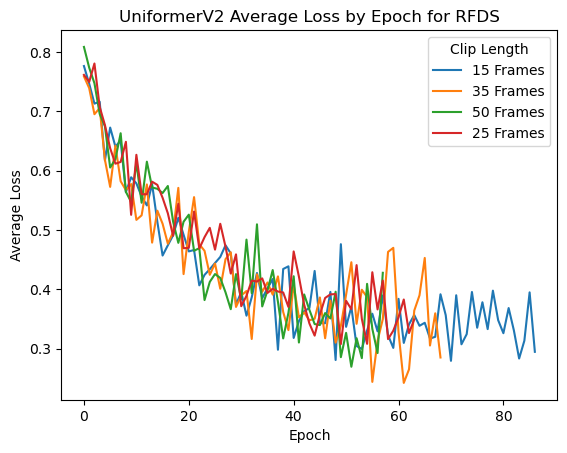

In [88]:
def parse_log_file_for_loss(file_path):
    results = []
    
    with open(file_path, 'r') as f:
        content = f.read()
        
    # Find all training results using regex
    train_pattern = r'Epoch\(train\)\s+\[(\d+)\]\[\s*(\d+)/\d+\].*?loss:\s+([\d.]+)'
    matches = re.finditer(train_pattern, content)
    
    for match in matches:
        epoch = int(match.group(1))
        loss = float(match.group(3))
        
        results.append({
            'epoch': epoch,
            'loss': loss
        })
    
    return results

def read_log_files_for_loss(directory):
    """
    Read all .log files from the given directory and its subdirectories.
    
    Args:
    directory (str): The root directory to search for .log files.
    
    Returns:
    pd.DataFrame: A DataFrame containing epoch and loss with file names prepended to columns.
    """
    all_dfs = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.log'):
                file_path = os.path.join(root, file)
                results = parse_log_file_for_loss(file_path)
                df = pd.DataFrame(results)
                df = df.groupby('epoch').mean().reset_index()  # Calculate average loss per epoch
                df.columns = [f"{file}_{col}" for col in df.columns]
                all_dfs.append(df)
    
    # Concatenate all DataFrames along the columns
    combined_df = pd.concat(all_dfs, axis=1)
    return combined_df


# Parameters for graphing
model = 'UniformerV2'
dataset = 'RFDS'

# Read log files from the specified directory
log_directory = f'/home/tommy/code/projectds/Models/MMACTION/{model}/Results'
df = read_log_files_for_loss(log_directory)


# Plot accuracy for each epoch
loss_columns = [col for col in df.columns if 'loss' in col and dataset in col]
df[loss_columns].plot()
legend_labels = [col.split('_')[1] + ' Frames' for col in accuracy_columns]
plt.legend(legend_labels, title='Clip Length')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title(f'{model} Average Loss by Epoch for {dataset}')
plt.savefig(f'{model}_{dataset}_loss.png')
plt.show()

# Highest accuracy and confusion matrix extraction

In [56]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

def parse_log_file(file_path):
    results = []
    
    with open(file_path, 'r') as f:
        content = f.read()
        
    # Find all validation results using regex
    val_pattern = r'Epoch\(val\)\s+\[(\d+)\].*?acc/top1:\s+([\d.]+).*?confusion_matrix/result:\s+tensor\(\[(\[[\d,\s]+\]),\s+(\[[\d,\s]+\])\]\)'
    matches = re.finditer(val_pattern, content, re.DOTALL)
    
    for match in matches:
        epoch = int(match.group(1))
        acc = float(match.group(2))
        
        # Parse confusion matrix rows
        row1 = eval(match.group(3))
        row2 = eval(match.group(4))
        
        results.append({
            'epoch': epoch,
            'accuracy': acc,
            'confusion_matrix': [row1, row2]
        })
    
    return results

def calculate_precision_recall(confusion_matrix):
    tp = confusion_matrix[0][0]
    fp = confusion_matrix[0][1]
    fn = confusion_matrix[1][0]
    tn = confusion_matrix[1][1]
    
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    
    return precision, recall

def read_log_files(directory):
    """
    Read all .log files from the given directory and its subdirectories.
    
    Args:
    directory (str): The root directory to search for .log files.
    
    Returns:
    pd.DataFrame: A DataFrame containing epoch, accuracy, and confusion_matrix with file names prepended to columns.
    """
    all_dfs = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.log'):
                file_path = os.path.join(root, file)
                results = parse_log_file(file_path)
                df = pd.DataFrame(results)
                df = df.set_index('epoch')
                df.columns = [f"{file}_{col}" for col in df.columns]
                all_dfs.append(df)
    
    # Concatenate all DataFrames along the columns
    combined_df = pd.concat(all_dfs, axis=1)
    return combined_df

def extract_highest_accuracy_confusion_matrices(df):
    highest_accuracy_confusion_matrices = []
    
    for col in df.columns:
        if 'accuracy' in col:
            file_name = "".join(col.split('_')[0:3])
            max_accuracy_row = df[col].idxmax()
            confusion_matrix_col = col.replace('accuracy', 'confusion_matrix')
            confusion_matrix = df.loc[max_accuracy_row, confusion_matrix_col]
            accuracy = df.loc[max_accuracy_row, col]
            highest_accuracy_confusion_matrices.append((file_name, accuracy, confusion_matrix))
    
    return highest_accuracy_confusion_matrices

# Example usage
log_directory = '/home/tommy/code/projectds/Models/MMACTION/UniformerV2/Results'

# Read log files from the specified directory
df = read_log_files(log_directory)

# Extract highest accuracy confusion matrices
highest_accuracy_confusion_matrices = extract_highest_accuracy_confusion_matrices(df)

# Print the results with accuracy, precision, and recall
for item in highest_accuracy_confusion_matrices:
    file_name, accuracy, confusion_matrix = item
    precision, recall = calculate_precision_recall(confusion_matrix)
    print(f"File: {file_name}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, Confusion Matrix: {confusion_matrix}")

File: UNI25RFDS-, Accuracy: 0.8286, Precision: 0.7481481481481481, Recall: 0.8782608695652174, Confusion Matrix: [[101, 34], [14, 131]]
File: UNI50RFDS-, Accuracy: 0.8824, Precision: 0.8378378378378378, Recall: 0.9253731343283582, Confusion Matrix: [[124, 24], [10, 131]]
File: UNI15HQFDS-, Accuracy: 0.8648, Precision: 0.9054054054054054, Recall: 0.8305785123966942, Confusion Matrix: [[402, 42], [82, 391]]
File: UNI15RFDS-, Accuracy: 0.7901, Precision: 0.8373983739837398, Recall: 0.7463768115942029, Confusion Matrix: [[103, 20], [35, 104]]
File: UNI35HQFDS-, Accuracy: 0.8739, Precision: 0.9217877094972067, Recall: 0.8305369127516778, Confusion Matrix: [[495, 42], [101, 496]]
File: UNI50HQFDS-, Accuracy: 0.9019, Precision: 0.8990683229813664, Recall: 0.910377358490566, Confusion Matrix: [[579, 65], [57, 542]]
File: UNI35RFDS-, Accuracy: 0.8333, Precision: 0.7972972972972973, Recall: 0.8676470588235294, Confusion Matrix: [[118, 30], [18, 122]]
File: UNI25HQFDS-, Accuracy: 0.8645, Precisio